## Below we are referencing the dataset and doing some very basic pre-processing to make our data look better

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from scipy import stats
from scipy.stats import shapiro

In [2]:
df = pd.read_csv('nyc-rolling-sales.csv')

# Reason for dropping EASE-MENT and Unnamed: 0
The column EASE-MENT is dropped because it is completely and does not serve any value in the prediction of house prices. 

We are dropping Unnamed: 0 as it seems to be an iterator and serves no real purpose in predicting house prices, it seems to  equate to AmountOfRows(x), x being the row. 

In [3]:
#Dropping column as it is empty
del df['EASE-MENT']
#Dropping as it looks like an iterator
del df['Unnamed: 0']

del df['SALE DATE']

In [4]:
#Checking for duplicated entries
sum(df.duplicated(df.columns))


1358

# Why are we removing duplicate values?
The reason we are removing the duplicates is because we are trying to avoid potential overfitting that might or might not be because of those duplicate values. but is not guaranteed as it just adds more weight to the data

In [5]:
#Delete the duplicates and check that it worked

df = df.drop_duplicates(df.columns, keep='last')
sum(df.duplicated(df.columns))

# Current duplicate values after removal: 0

0

In [6]:
# onverting some of the columns to appropriate datatype

df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
#df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['BOROUGH'] = df['BOROUGH'].astype('category')

In [7]:
#checking missing values

df.columns[df.isnull().any()]

Index(['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE'], dtype='object')

In [8]:
# organizing the columns with missing values including its values

miss=df.isnull().sum()/len(df)
miss=miss[miss>0]
miss.sort_values(inplace=True)
miss

SALE PRICE           0.167196
LAND SQUARE FEET     0.312213
GROSS SQUARE FEET    0.327888
dtype: float64

In [9]:
# doing the same as previous box, but with better aesthetics. 

miss=miss.to_frame()
miss.columns=['count']
miss.index.names=['Name']
miss['Name']=miss.index
miss

,count,Name
Name,,
SALE PRICE,0.167196,SALE PRICE
LAND SQUARE FEET,0.312213,LAND SQUARE FEET
GROSS SQUARE FEET,0.327888,GROSS SQUARE FEET


# Why fill up the columns?
All these missing values can be data corruption or failure to record data. To handle these different missing data is a very important part of the pre-processing. Including, many machine-learning algorithms do not support all these missing values, and therefor needs to be delt with. And the way we choose to deal with them, is get the mean value of the column, and replace the missing values with that average value. Deleting all the rows that are missing values can cause detrimental changes to the prediction of the algorithms, and in worst case scenario make it predict a lot worse than it could have. 

In [10]:
# FIlling up columns with mean value to replace the missing values.
df['LAND SQUARE FEET']=df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET']=df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())

In [11]:
# Splitting dataset 
test=df[df['SALE PRICE'].isna()]
data=df[~df['SALE PRICE'].isna()]

In [12]:
test = test.drop(columns='SALE PRICE')

In [13]:
# Print first 5 rows of test
print(test.shape)
test.head()

(13909, 18)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,,10009,28,3,31,4616.0,18690.0,1900,2,C7
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,,10009,16,1,17,2212.0,7803.0,1900,2,C7
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,C4,516 EAST 12TH STREET,,10009,20,0,20,2581.0,9730.0,1900,2,C4
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,C7,520 EAST 14TH STREET,,10009,44,2,46,5163.0,21007.0,1900,2,C7
8,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,D5,141 AVENUE D,,10009,15,0,15,1534.0,9198.0,1920,2,D5


# Checking for outliers

Seeing as we have been dealt a huge dataset, outliers are to be expected. So, to handle this accordingly, first located the outliers by plotting them on a boxplot, and then filtered out appropriate variable ranges. Outliers can indicate errors in data collection but in the case of our data, errors in collecting data don't seem very probable.
## Why is it important to remove outliers?
Outliers can play a role in causing immense difficulties in the process of statistical analysis, as they represent a situation/scenario which is extremely unlikely to play out again. In the case of our dataset, outliers are entries in which massive amounts of total units are bought (example of this could be the sale of an apartment building, or a few floors thereof), which would have better fit our data if they were broken down entered as multiple sales of a smaller amount of units. 

# What are these visualizations below?
These visualizations are to display all the different values in a specific column, and how far they are away from eachother compared to the aboslute minimum and maximum value. This is done using boxplot inside of the seaborn package. Here you just do seaborn.boxplot(x=dataframe["name of column you would like to display"])

<AxesSubplot:xlabel='SALE PRICE'>

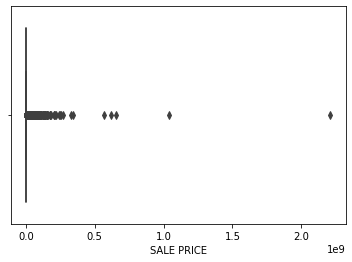

In [14]:
sns.boxplot(x=data["SALE PRICE"])

<AxesSubplot:xlabel='TOTAL UNITS'>

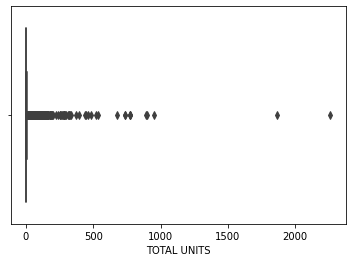

In [15]:
sns.boxplot(x=data["TOTAL UNITS"])

# Removing the outliers

In [16]:
# Removing rows that contains outliers in both TOTAL UNITS and SALE PRICE. 
data = data[(data['TOTAL UNITS'] > 0) & (data['TOTAL UNITS'] < 1500)] 
data = data[(data['SALE PRICE'] > 100000) & (data['SALE PRICE'] < 5000000)] 

# Visualizing that the outliers are removed from the dataset

<AxesSubplot:xlabel='SALE PRICE'>

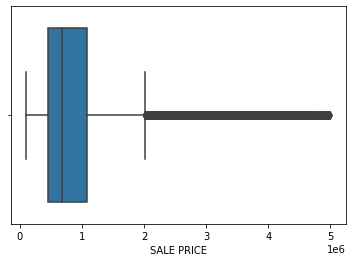

In [17]:
sns.boxplot(x=data["SALE PRICE"])

<AxesSubplot:xlabel='TOTAL UNITS'>

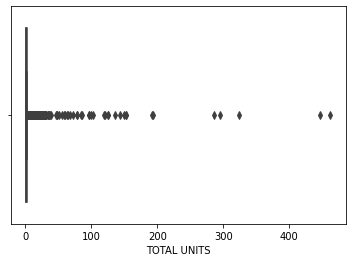

In [18]:
sns.boxplot(x=data["TOTAL UNITS"])

# Below is pre-proccessing of dataset (Regression models)

---------------------------------------------------------------------------------------------
# Why is apartment number and address getting dropped?

The apartment number column is irrelevant, and removed due to the column being practically lacking half of its elements. Thus we simply do not have enough values to create a useful mean value to replace the empty slots with, as well as if we were to just leave it, the consequence would be alot of zero values which would greatly affect the price. The values are also lacking name consistency which also makes it harder to pre-process due to them being very different in value.

We are dropping address due to the values lacking name consistency making it very hard to pre-process due to there being to many combinations of address names to make sensable pre-proccessing of it.

In [19]:
# deleting some irrelevant columns!
# Explanation above.

del data['ADDRESS']
del data['APARTMENT NUMBER']

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39003 entries, 3 to 84545
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         39003 non-null  category
 1   NEIGHBORHOOD                    39003 non-null  object  
 2   BUILDING CLASS CATEGORY         39003 non-null  object  
 3   TAX CLASS AT PRESENT            39003 non-null  category
 4   BLOCK                           39003 non-null  int64   
 5   LOT                             39003 non-null  int64   
 6   BUILDING CLASS AT PRESENT       39003 non-null  object  
 7   ZIP CODE                        39003 non-null  int64   
 8   RESIDENTIAL UNITS               39003 non-null  int64   
 9   COMMERCIAL UNITS                39003 non-null  int64   
 10  TOTAL UNITS                     39003 non-null  int64   
 11  LAND SQUARE FEET                39003 non-null  float64 
 12  GROSS SQUARE FEET 

In [21]:
numeric_data=data.select_dtypes(include=[np.number])

# Checking for skewness
We check for skewness because we have in our dataset a large number of moderately priced houses, and some highly priced houses. this can be an indication that the data for specific values are skewed to the right side, which means you are predicting a much larger amount of moderately priced houses, and might cause the model to have a harder time predicitng the price for the more higher priced houses. 

One way to test this is by doing what is called Shapiro-Wilks test. the null hypotheses for this specific test is that the data is a sample from a normal distribution, so the p-value less than 0.05 indicates significant skewness. 

In [22]:
stats.shapiro(data["SALE PRICE"])

ShapiroResult(statistic=0.7484854459762573, pvalue=0.0)

Another way of testing for skewness, is using pandas skew() method. it calculates the Fisher-Pearson standardized moment coefficient for all collumns in a dataframe. 

In [23]:
from scipy.stats import skew
num_feats = data.dtypes[data.dtypes!="object"].index
skew_feats = data[num_feats].skew().sort_values(ascending=False)
skewness=pd.DataFrame({"Skew":skew_feats})
skewness

,Skew
LAND SQUARE FEET,97.176872
COMMERCIAL UNITS,95.309583
RESIDENTIAL UNITS,54.045558
GROSS SQUARE FEET,53.045021
TOTAL UNITS,51.674276
LOT,2.852163
SALE PRICE,2.308921
BLOCK,0.921536
YEAR BUILT,-3.569420
ZIP CODE,-5.006578


# Transforming skewed data using log(x + 1)
There is a way we can address skewed variables, and reduce the skewness of our current dataset. That way is by transforming them. This can be done by either including square root (sqrt(x)), logarithmic (log(x)) and reciprocal (1/x). For our data we have chosen to go the logarithmic route. 

In [24]:
#transform the numeric features using log(x + 1)
# skew is the degree of distortion from a normal distribution.
# THe reason we chose to skew the data is so the models can predict the more expensive houses more accurately

from scipy.stats import skew
skewed = data[numeric_data.columns].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
data[skewed] = np.log1p(data[skewed])

In [25]:
data["SALE PRICE"] = data["SALE PRICE"]**(.5)

In [26]:
stats.shapiro(data["SALE PRICE"])

ShapiroResult(statistic=0.9918535947799683, pvalue=8.906512909402105e-41)

# Checking data for gaussian distribution

Text(0.5, 1.0, 'Normality Check')

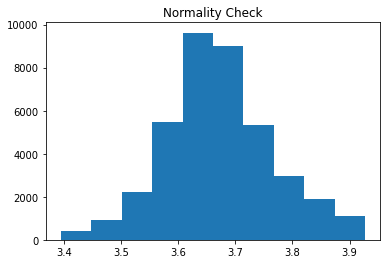

In [27]:
plt.hist(data['SALE PRICE'])
plt.title("Normality Check")

In [28]:
std = np.std(data['SALE PRICE'], ddof=1)
mean = np.mean(data['SALE PRICE'])

# Why standardization and not normalization of data?
Standarization a dataset involves rescaling the distribution of values so that the mean of observed is 0 and the standard deviation is 1. 

Standization can be very useful. and in some algorithms, it is even required. but standardization does assume that your observations fit a gaussian distribution. The data can still standardized even if these expectations are not met, but the results may not be as reliable. 

Compared to the figure you see under the title "Checking data for gaussian distribution" above this section, you can see that bell curve that signifies that the data fits a gaussian distribution. Therefor the standard scaler fits our project well as it standardizes our data instead of normalizing it. 

Had we not removed our outliers, we would have gone with the RobustScaler which works well with outliers. 


In [29]:

# Scaling data the numeric data

scaler = StandardScaler()
scaler.fit(data[numeric_data.columns])
scaled = scaler.transform(data[numeric_data.columns])

for i, col in enumerate(numeric_data.columns):
       data[col] = scaled[:,i]

In [30]:
#Dropping few columns that is not needed
del data['BUILDING CLASS AT PRESENT']
del data['BUILDING CLASS AT TIME OF SALE']
del data['NEIGHBORHOOD']

In [31]:
#Select the variables to be one-hot encoded
# We one hot encode this data so that the models can predict more accurately given the data they have. 
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE']

# Why do we one-hot encode the different categorical columns? 
A one-hot encoding allows for more expressive categorical data representation. Many machine learning algorithms are unable to work directly with categorical data. The categories must be numerically converted. This is required for categorical input and output variables.

# Under here we are one-hot encoding categorical columns

One-hot encoding is practically a way of representing categorical variables binary vectors, this also requires the categorical data has been mapped in to integer values, or else you will get an error message

In [32]:
one_hot_encoded = pd.get_dummies(data[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39003 entries, 3 to 84545
Data columns (total 58 columns):
 #   Column                                                                Non-Null Count  Dtype
---  ------                                                                --------------  -----
 0   BOROUGH_1                                                             39003 non-null  uint8
 1   BOROUGH_2                                                             39003 non-null  uint8
 2   BOROUGH_3                                                             39003 non-null  uint8
 3   BOROUGH_4                                                             39003 non-null  uint8
 4   BOROUGH_5                                                             39003 non-null  uint8
 5   BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                       39003 non-null  uint8
 6   BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                       39003 non-null  uint8
 7   BUILDING CLAS

In [33]:
# Replacing categorical columns with dummies
fdf = data.drop(one_hot_features,axis=1)
fdf = pd.concat([fdf, one_hot_encoded] ,axis=1)

In [34]:
# Dividing dataset in to Data and Target values.

Y_fdf = fdf['SALE PRICE']
X_fdf = fdf.drop('SALE PRICE', axis=1)

X_fdf.shape , Y_fdf.shape

((39003, 67), (39003,))

In [35]:
# Splitting the dataset in to a test set and a training set

X_train ,X_test, Y_train , Y_test = train_test_split(X_fdf , Y_fdf , test_size = 0.3 , random_state =34)

# Reason for using RMSE instead of just R2. 

R-squared is conventiently scaled between 0 and 1, whereas RMSE is not scaled to any particular values. This can be good or bad; obviously R-squared can be more easily interpreted, but with RMSE we explcitly know how much our predictions deviate, on average, from the actual values in the dataset. So in a way, RMSE tells you more. 

In [36]:
# setting up a RMSE
# Lower Score = Better Score. Lower > Higher.
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

# Here is the Regression models we have chosen for our project. 
- Support Vector Machine (SVM)
- K Neighbor Regressor
- Random Forest Regressor
- Decision Tree Regressor
- Multi Layer Perceptron Regressor (MLPR)(Neural Network)

# Support Vector Machine
The Support Vector Machine (or SVM) is a linear classifier. The SVM will take in data points, and compute the best "Hyperplane", a line which seperates data into their respective classes. This hyperplane is computed based on the margin between the line and closest data point of that class. It seeks to maximize this margin, and be as far away from the datapoints of each class as possible.

We use the Support Vector Regressor from the svm package, which uses generally the same principles, with only a few differences. As output is a real number, prediction becomes difficult. As a result of these difficulties, a margin of tolerance is set.

In [37]:
from sklearn import svm
supportvectormachine = svm.SVR(C=1)
supportvectormachine.fit(X_train, Y_train)

SVR(C=1)

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        },
        cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

In [ ]:
grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
best_svr = SVR(kernel='rbf', C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=2, max_iter=-1)
#Verbose = 2 *****

Fitting 5 folds for each of 308 candidates, totalling 1540 fits


In [61]:
print("best params", grid_result.best_params_)

best params {'C': 1, 'epsilon': 0.1, 'gamma': 1}


In [49]:
predictions = supportvectormachine.predict(X_test)
# predictions = scaler.inverse_transform(predictions)
predictions

array([ 1.02171121, -0.44915881, -2.49490954, ...,  0.43039892,
       -1.01373686, -0.12033419])

In [50]:
supportvectormachine.support_vectors_

array([[-0.66559413,  1.20167382, -1.40917184, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.45698758,  1.37057494,  0.73010031, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.13351184, -0.03307239,  0.86028892, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.26910378, -0.44199277,  0.73170757, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00748847, -1.28209168, -0.95913713, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22937614, -1.28209168,  0.50026115, ...,  0.        ,
         0.        ,  0.        ]])

In [51]:
supportvectormachine.support_

array([    1,     2,     4, ..., 27299, 27300, 27301])

In [52]:
print(supportvectormachine.score(X_test, Y_test))
print(f"RMSE Score: {rmse(Y_test, predictions)}")


0.5617892680452916
RMSE Score: 0.6574965275058103


# K Neighbors Regressor
The score on this model was fairly low as KNearest models does not work that well on big datasets, we decided to include it anyways as it is just as important to analyze a method in suboptimal conditions as it is to study it in optimal conditions.

K Nearest Neighbors Regression is a non-parametric method that seeks to estimate the association between independent variables and continuous outcomes by averaging observations in their respective neighborhoods. Therefore, the analyst must determine the neighborhood size, K. We found that a K value of 8 best suited our intentions.

In [42]:
from sklearn.neighbors import KNeighborsRegressor
kneighborsregressor = KNeighborsRegressor(n_neighbors=8)
kneighborsregressor.fit(X_train, Y_train)

KNeighborsRegressor(n_neighbors=8)

In [43]:
predictions = kneighborsregressor.predict(X_test)
predictions

array([ 1.01862627, -0.47499111, -2.45790048, ...,  0.3838277 ,
       -1.16435619, -0.48851349])

In [44]:
kneighborsregressor.kneighbors_graph(X_train).toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [45]:
print(f"R2 Score: {kneighborsregressor.score(X_test, Y_test)}")
print(f"RMSE Score: {rmse(Y_test, predictions)}")

R2 Score: 0.6296250473768397
RMSE Score: 0.604467232565021


# Random Forest Regressor
Loosely; a random forest regressor constructs several decision trees, then outputs the mean of the classes as the prediction of all the trees. Although random forest regressors are powerful and accurate, and work well in a wide range of cases, there is no interpretability, and we must be vigilant towards overfitting.

In [46]:
rf_regr = RandomForestRegressor(criterion="mse", n_estimators=1000, max_features="sqrt", 
                               n_jobs=-1, random_state=1234)
rf_regr.fit(X_train, Y_train)
Y_pred_rf = rf_regr.predict(X_test)
print(f"RMSE Score: {rmse(Y_test,Y_pred_rf)}")
print(f"R2 Score: {rf_regr.score(X_test, Y_test)}")

RMSE Score: 0.6550874339171374
R2 Score: 0.5649946282999401


# Decision tree regressor
A good way to visualize a decision tree, is to visualize it as a serious of questions that is asked about the input data, each question eliminating possible values until the model is confident enough to reach a conclusion. It is important to note that all questions asked to the input data are formed in True/False manner.
First, the model is trained with relevant historical data. The model then calculates appropriate questions, and question order, based on an analysis it does on the relationships between the data and the target variable (These calculations can be done by hand with a metric like gini impurity). 

In [50]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(criterion="friedman_mse")
dtr.fit(X_train, Y_train)
pred = dtr.predict(X_test)
print(f"RMSE Score: {rmse(Y_test, pred)}")
print(f"R2 Score: {dtr.score(X_test, Y_test)}")


RMSE Score: 0.7470789465530165
R2 Score: 0.4342441180333222


# Random Forest vs Decision Tree
In our different tree models, which was decision tree regressor and a random forest regressor. in our models, our random forest regressor clearly beat our decision tree regressor by quite a mark. here are the results

Decision Tree R2: 0.42
Decision Tree RMSE: 0.75

Random Forest R2: 0.68
Random Forest RMSE: 0.55

When it comes to comparing these models, random forest leverages the power of multiple decision trees, instead of relying on feaure importance given by a single decision tree. Random forest also chooses features randomly during the training process, which is a special characterstic of random forrest over bagging tree's, which is a variance of a decision tree where the goal is to reduce the variance of a decision tree.

Since random forest uses more tree's, it will take longer to train the data, as it has to train each individual tree, which will increase the time taken by AmountOfTrees(x), while decision trees focuses more on speed due to only having to train one decision tree.  

We can also see that the decision tree deviate further away from the correct answer on avarage, as shown in the RMSE score on both parts.

# Setting up a Multi Layer Perceptron Regressor (Without Hyper Parameter Tuning)
A Multi Layer Perceptron, is like a perceptron in the sense that it has an input layer and output layer which are connected, but an MLP can have many hidden layers in between the input and output layer. In forward passing, the input flows from the input layer through all the hidden layers and then to the output layer, where a decision is made and measured against the ground truth labels. Essentially, the multilayer perceptron is just a series of perceptron algorithms, a neural network. Each layer (perceptron) will multiply with weights and add bias, to come to a conclusion.

# Solver Paramter Explanation (adam)
We chose the optimization algorithm adam. the reason we chose it, is because it has little memory requirements, it is computationally efficient, as well as it is well suited for problems that are large in terms of data and/or paramters. and in our dataset, we have a quite large dataset to work with, therefor adam works well in our case. 

In [218]:
from sklearn.neural_network import MLPRegressor 
mlpregressor = MLPRegressor(random_state=1, max_iter=400, solver="adam")
mlpregressor.fit(X_train,Y_train)

print("R2 Score:",mlpregressor.score(X_test, Y_test))
predictions = mlpregressor.predict(X_test)
print(f"RMSE Score: {rmse(Y_test, predictions)}")

# CODE WONT BE EXECUTED; SO WHEN YOU RUN THIS PART. STOP THE KERNAL WHEN YOU HAVE RAN IT

R2 Score: 0.5943961823384292
RMSE Score: 0.6325618206955922


# Doing A version of hyper parameter tuning to find the best possible parameters for the MLPRegressor
We are using sklearns inbuilt package called GridSearchCV, which does grid search including an x amount of cross validations that can be set in the parameters. we do this to test all the different combinations of parameters to check which parameters is giving us our best score. 


In [219]:
check_parameters = {
    'hidden_layer_sizes': [(50,50), (100,50), (150, 100), (12, 6)],
    'activation': ['tanh', 'relu', 'logistic'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [220]:
try:
    gridsearchcv = GridSearchCV(mlpregressor, check_parameters, n_jobs=-1, cv=3)
    gridsearchcv.fit(X_train, Y_train)
except KeyboardInterrupt:
    print("You stopped the program, therefor it is not running anymore")
    
# THIS TAKES OVER 30 MINUTES TO COMPLETE, SO DO NOT RUN THIS LINE; NOR THE ONE BELOW

# Here is the output for the line below:  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50),
#'learning_rate': 'constant', 'solver': 'adam'}

In [221]:
print('Best parameters found:\n', gridsearchcv.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}


# MLPRegressor with Hyper Parameter Tuning applied

In [222]:
mlpregressor = MLPRegressor(random_state=1, max_iter=400, activation='tanh', alpha=0.0001, hidden_layer_sizes=(150, 100), 
                           learning_rate = "constant", solver = "adam")
mlpregressor.fit(X_train,Y_train)

print("R2 Score:",mlpregressor.score(X_test, Y_test))
print(f"RMSE score: {rmse(Y_test, predictions)}")

R2 Score: 0.6205151346076112
RMSE score: 0.6325618206955922
